In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
from utils import *
from docplex.mp.model import Model
import os

In [3]:
fname = "..\\..\\raw_data\\NRP\\NRC\\Instance6.txt"
problem = NRCProblem()
problem.load_from_txt(fname)


In [4]:
problem.save_to_json("..\\..\\data\\NRP\\NRC\\Instance6.json")

In [6]:
best = {'Instance1':		{'weeks':2,		'employees':8, 	'Shift types':1, 	"optimum":607},
'Instance2':		{'weeks':2,		'employees':14, 	'Shift types':2, 	"optimum":828},
'Instance3':		{'weeks':2,		'employees':20, 	'Shift types':3, 	"optimum":1001},
'Instance4':		{'weeks':4,		'employees':10, 	'Shift types':2, 	"optimum":1716},
'Instance5':		{'weeks':4,		'employees':16, 	'Shift types':2, 	"optimum":1143},
'Instance6':		{'weeks':4,		'employees':18, 	'Shift types':3, 	"optimum":1950},
'Instance7':		{'weeks':4,		'employees':20, 	'Shift types':3, 	"optimum":1056},
'Instance8':		{'weeks':4,		'employees':30, 	'Shift types':4, 	"optimum":1300},
'Instance9':		{'weeks':4,		'employees':36,		'Shift types':4, 	"optimum":439},
'Instance10':		{'weeks':4,		'employees':40, 	'Shift types':5, 	"optimum":4631},
'Instance11':		{'weeks':4,		'employees':50, 	'Shift types':6, 	"optimum":3443},
'Instance12':		{'weeks':4,		'employees':60,		'Shift types':10, 	"optimum":4040},
'Instance13':		{'weeks':4,		'employees':120, 	'Shift types':18, 	"optimum":1348},
'Instance14':		{'weeks':6,		'employees':32,		'Shift types':4, 	"optimum":1278},
'Instance15':		{'weeks':6,		'employees':45, 	'Shift types':6, 	"optimum":3829},
'Instance16':		{'weeks':8,		'employees':20, 	'Shift types':3, 	"optimum":3225},
'Instance17':		{'weeks':8,		'employees':32, 	'Shift types':4, 	"optimum":5746},
'Instance18':		{'weeks':12,		'employees':22,		'Shift types':3, 	"optimum":4459},
'Instance19':		{'weeks':12,		'employees':40, 	'Shift types':5, 	"optimum":3149},
'Instance20':		{'weeks':26,		'employees':50, 	'Shift types':6, 	"optimum":4769},
'Instance21':		{'weeks':26,		'employees':100,		'Shift types':8, 	"optimum":21133},
'Instance22':		{'weeks':52,		'employees':50, 	'Shift types':10, 	"optimum":30241},
'Instance23':		{'weeks':52,		'employees':100, 	'Shift types':16, 	"optimum":17428},
'Instance24':		{'weeks':52,		'employees':150, 	'Shift types':32, 	"optimum":42463}}

In [11]:
folder = "..\\..\\raw_data\\NRP\\NRC\\"
for file in os.listdir(folder):
    if file.endswith(".txt"):
        problem = NRCProblem()
        problem.load_from_txt(os.path.join(folder, file))
        
        info = best[file.replace(".txt", "")]
        
        data = {
            "weeks": info['weeks'],
            "employees": info['employees'],
            "shift_types": info['Shift types']
        }
        data.update(problem.__dict__)
        
        instance = {
        "benchmark_name": "NRC",
        "instance_name": file.replace(".txt", ""),
        "instance_kind": "NRP",
        "reference_solution": {
            "optimum": info["optimum"],
        },
        "data": data,
        "run_history": []
        }
        
        with open("..\\..\\data\\NRP\\NRC\\{}.json".format(file.replace(".txt", "")), "w") as f:
            json.dump(instance, f, indent=4)
    
        # break

In [15]:
problem2 = NRCProblem()
problem2.load_from_json("..\\..\\data\\NRP\\NRC\\Instance6.json")


In [ ]:
# TODO: idea with sequences

# all_shifts = all_shifts + ['VACATION']
#
# assigned = [mdl.sequence_var([shift for shift in all_shifts], types=[shift for shift in all_shifts], name="nurse_{}".format(nurse)) for nurse in all_nurses]

# print("assigned: ", assigned)

In [16]:
mdl = Model(name="nurses")

# first global collections to iterate upon
all_nurses = problem.staff.keys()
all_shifts = problem.shifts.keys()
all_days = list(range(problem.horizon))

# the assignment variables.
assigned = mdl.binary_var_cube(keys1=all_nurses, keys2=all_days, keys3=all_shifts, name="assign_%s_%s_%s")
print("assigned: ", assigned)

assigned:  {('A', 0, 'E'): docplex.mp.Var(type=B,name='assign_A_0_E'), ('A', 0, 'D'): docplex.mp.Var(type=B,name='assign_A_0_D'), ('A', 0, 'L'): docplex.mp.Var(type=B,name='assign_A_0_L'), ('A', 1, 'E'): docplex.mp.Var(type=B,name='assign_A_1_E'), ('A', 1, 'D'): docplex.mp.Var(type=B,name='assign_A_1_D'), ('A', 1, 'L'): docplex.mp.Var(type=B,name='assign_A_1_L'), ('A', 2, 'E'): docplex.mp.Var(type=B,name='assign_A_2_E'), ('A', 2, 'D'): docplex.mp.Var(type=B,name='assign_A_2_D'), ('A', 2, 'L'): docplex.mp.Var(type=B,name='assign_A_2_L'), ('A', 3, 'E'): docplex.mp.Var(type=B,name='assign_A_3_E'), ('A', 3, 'D'): docplex.mp.Var(type=B,name='assign_A_3_D'), ('A', 3, 'L'): docplex.mp.Var(type=B,name='assign_A_3_L'), ('A', 4, 'E'): docplex.mp.Var(type=B,name='assign_A_4_E'), ('A', 4, 'D'): docplex.mp.Var(type=B,name='assign_A_4_D'), ('A', 4, 'L'): docplex.mp.Var(type=B,name='assign_A_4_L'), ('A', 5, 'E'): docplex.mp.Var(type=B,name='assign_A_5_E'), ('A', 5, 'D'): docplex.mp.Var(type=B,name='a

In [17]:
# vacations

vacations = []

for nurse in problem.days_off.keys():
    for day in problem.days_off[nurse]:
        # print(nurse, day)
        for shift in problem.cover_requirements:
            if shift['Day'] == day:
                temp = assigned[nurse, shift['Day'], shift['ShiftID']]
                vacations.append(temp)
                mdl.add_constraint(temp == 0)
        # for day in days:
        #     vacations.append(assigned[nurse, day])

print("vacations: ", vacations)

vacations:  [docplex.mp.Var(type=B,name='assign_A_18_E'), docplex.mp.Var(type=B,name='assign_A_18_D'), docplex.mp.Var(type=B,name='assign_A_18_L'), docplex.mp.Var(type=B,name='assign_A_19_E'), docplex.mp.Var(type=B,name='assign_A_19_D'), docplex.mp.Var(type=B,name='assign_A_19_L'), docplex.mp.Var(type=B,name='assign_B_24_E'), docplex.mp.Var(type=B,name='assign_B_24_D'), docplex.mp.Var(type=B,name='assign_B_24_L'), docplex.mp.Var(type=B,name='assign_B_25_E'), docplex.mp.Var(type=B,name='assign_B_25_D'), docplex.mp.Var(type=B,name='assign_B_25_L'), docplex.mp.Var(type=B,name='assign_C_22_E'), docplex.mp.Var(type=B,name='assign_C_22_D'), docplex.mp.Var(type=B,name='assign_C_22_L'), docplex.mp.Var(type=B,name='assign_C_23_E'), docplex.mp.Var(type=B,name='assign_C_23_D'), docplex.mp.Var(type=B,name='assign_C_23_L'), docplex.mp.Var(type=B,name='assign_D_4_E'), docplex.mp.Var(type=B,name='assign_D_4_D'), docplex.mp.Var(type=B,name='assign_D_4_L'), docplex.mp.Var(type=B,name='assign_D_5_E'), d

In [18]:
# max 1 shift per day

for nurse in all_nurses:
    for day in all_days:
        mdl.add_constraint(mdl.sum(assigned[nurse, day, shift] for shift in all_shifts) <= 1)

In [21]:
# eliminate following shifts

for nurse in all_nurses:
    for day in all_days[:-1]:
        for shift in all_shifts:
            forbidden = problem.shifts[shift]['CannotFollow']
            # print(forbidden)
            if len(forbidden) > 0:
                mdl.add_constraint(assigned[nurse, day, shift] + mdl.sum(assigned[nurse, day + 1, f] for f in forbidden) <= 1)


In [ ]:
# The maximum numbers of shifts of each type that can be assigned to employees.

for nurse in all_nurses:
    for shift in all_shifts:
        mdl.add_constraint(mdl.sum(assigned[nurse, day, shift] for day in all_days) <= problem.staff[nurse][shift])

In [ ]:
# Minimum and maximum work time

for nurse in all_nurses:
    mdl.add_constraint(mdl.sum(assigned[nurse, day, shift] * problem.shifts[shift]['Duration'] for day in all_days for shift in all_shifts) >= problem.staff[nurse]['MinWorkTime'])
    mdl.add_constraint(mdl.sum(assigned[nurse, day, shift] * problem.shifts[shift]['Duration'] for day in all_days for shift in all_shifts) <= problem.staff[nurse]['MaxWorkTime'])

In [24]:
# Maximum consecutive shifts. The maximum number of shifts an employee can work without a day off.
# Each nurse can work at most 'max_consecutive_shifts' consecutive days.

for nurse in all_nurses:
    max_consecutive_shifts = problem.staff[nurse]['max_consecutive_shifts']
    for day in all_days[:-max_consecutive_shifts]:
        mdl.add_constraint(mdl.sum(assigned[nurse, day + i, shift] for i in range(max_consecutive_shifts) for shift in all_shifts) <= max_consecutive_shifts)


In [ ]:
# Minimum consecutive shifts.

for nurse in all_nurses:
    min_consecutive_shifts = problem.staff[nurse]['min_consecutive_shifts']
    for day in all_days[:-min_consecutive_shifts]:
        mdl.add_constraint(mdl.sum(assigned[nurse, day + i, shift] for i in range(min_consecutive_shifts) for shift in all_shifts) >= min_consecutive_shifts)

In [ ]:
# Minimum consecutive days off

for nurse in all_nurses:
    min_consecutive_days_off = problem.staff[nurse]['min_consecutive_days_off']
    for day in all_days[:-min_consecutive_days_off]:
        mdl.add_constraint(mdl.sum(not assigned[nurse, day + i, shift] for i in range(min_consecutive_days_off) for shift in all_shifts) == 0)


In [13]:
from src.general_optimization_solver import *
from src.nrp.solvers.solver_cp import NRPSolver
solvers_config = {"TimeLimit": 5}
solver = NRPSolver(**solvers_config)
path = "..\\..\\data\\NRP\\NRC\\Instance6.json"
instance = load_instance(path)

Time limit set to 5 seconds
..\..\data\NRP\NRC\Instance6.json


ValueError: Invalid instance kind, should be one of: MMRCPSP, RCPSP, JOBSHOP, found NRP

In [ ]:
ret = solver.solve(instance, validate=True, visualize=True)

In [4]:
for s in range(1, 2):
    print(s)

1


In [5]:
for s in range(1, 1):
    print(s)

In [26]:
max = 2
print(list(range(14)))
for s in range(1, max):
    for day in range(8, 13 - s):
        print(f"+{day} + {s} - {list(i + day for i in range(1, s + 1))} + {day + s + 1}")
    print()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
+8 + 1 - [9] + 10
+9 + 1 - [10] + 11
+10 + 1 - [11] + 12
+11 + 1 - [12] + 13


Time limit set to 500 seconds
Building model
Looking for solution
 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Minimization problem - 4400 variables, 6114 constraints
 ! Presolve      : 4596 extractables eliminated
 ! TimeLimit            = 500
 ! LogVerbosity         = Terse
 ! Initial process time : 0.09s (0.09s extraction + 0.00s propagation)
 !  . Log search space  : 14926.0 (before), 14926.0 (after)
 !  . Memory usage      : 6.5 MB (before), 6.5 MB (after)
 ! Using parallel search with 12 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0       4400                 -
 + New bound is 0
                        0       3278    1   F        -
 + New bound is 3
                      229       3071    1   F     1 != assign_%s_%s_%s_1455
 + New bound is 4
 *    9.0072e+15    27792  2.47s       11      (gap is 100.00%)
 *    

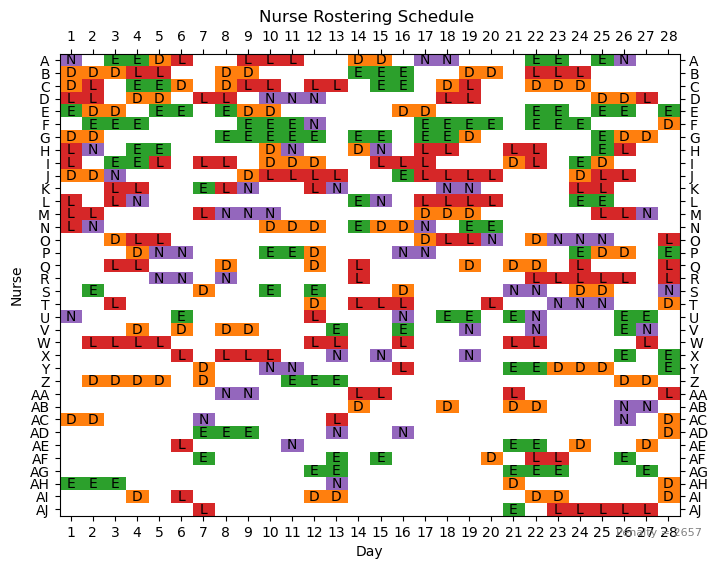

Validating solution...
[['N' ' ' 'E' ... 'N' ' ' ' ']
 ['D' 'D' 'D' ... ' ' ' ' ' ']
 ['D' 'L' ' ' ... ' ' ' ' ' ']
 ...
 ['E' 'E' 'E' ... ' ' ' ' 'D']
 [' ' ' ' ' ' ... ' ' ' ' 'D']
 [' ' ' ' ' ' ... 'L' 'L' ' ']]
Solution is valid.
Objective value: 2657
Feasible solution found
Solution is 505.2 % worse than the optimum.


In [27]:
from src.general_optimization_solver import *
from src.nrp.solvers.solver_cp import NRPSolver

solvers_config = {"TimeLimit": 500}
solver = NRPSolver(**solvers_config)
path = "..\\..\\data\\NRP\\NRC\\Instance9.json"
instance = load_instance(path)
ret = solver.solve(instance, validate=True, visualize=True)